In [1]:
from models import NetworkedRENs, REN, RNNModel
import numpy as np
import matplotlib.pyplot as plt
import scipy
import os

os.environ['PYTORCH_ENABLE_MPS_FALLBACK'] = '1'
from os.path import dirname, join as pjoin
import torch
from torch import nn

In [2]:
dtype = torch.float
device = torch.device("cpu")

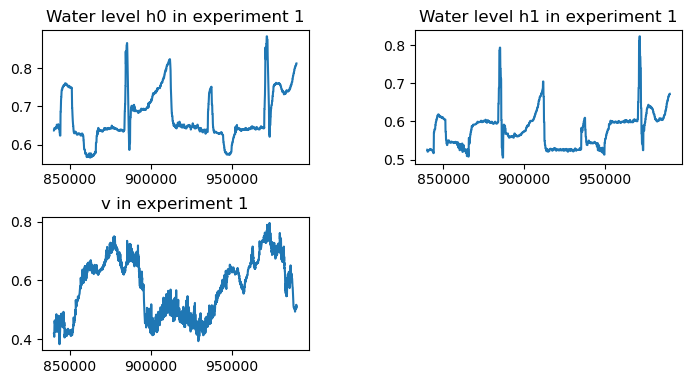

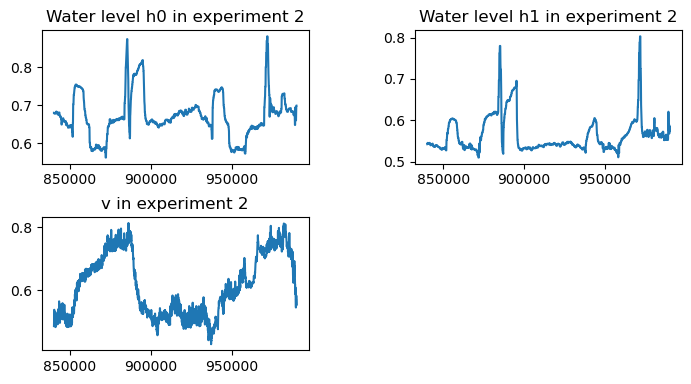

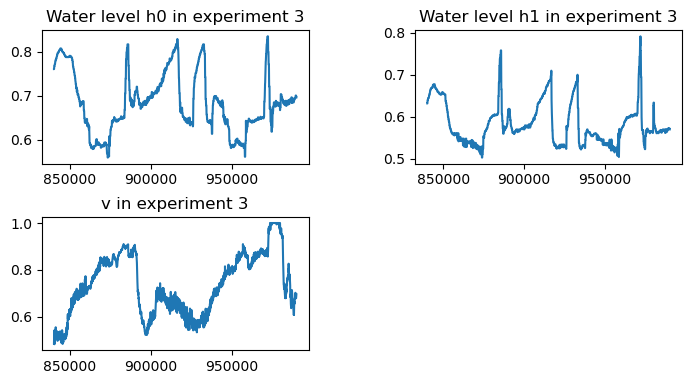

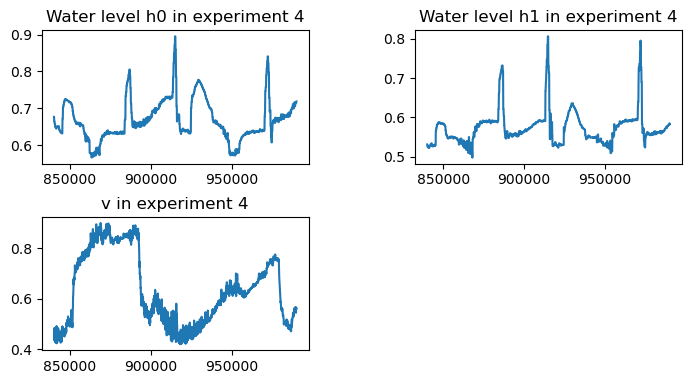

In [ ]:
# Import Data
folderpath = os.getcwd()
filepath = pjoin(folderpath, 'input_3.mat')#'dataset_sysID_3tanks.mat')
data_in = scipy.io.loadmat(filepath)
filepath = pjoin(folderpath, 'output_Q_3.mat')
data_out = scipy.io.loadmat(filepath)
filepath = pjoin(folderpath, 'subsystems.mat')
data_sub = scipy.io.loadmat(filepath)

filepath = pjoin(folderpath, 'denormalize.mat')
data_max = scipy.io.loadmat(filepath)

# Extract data from dictionary
maxTrit, maxTdel, maxTabs, maxTchill = data_max['maxTrit'], data_max['maxTman'], data_max['maxTabs'], data_max['maxTchill']
Toutass_t, Toutass_v, Toutchill_t, Toutchill_v = data_sub['Toutass_train'], data_sub['Toutass_val'], data_sub['Toutchillers_train'], data_sub['Toutchillers_val']
dExp, yExp, dExp_val, yExp_val, time__, buildtot, buildtot_val = data_in['dExp'], data_out['yExp'], \
    data_in['dExp_val'], data_out['yExp_val'], data_in['time__'], data_out['buildtotnorm'], data_out['buildtotnorm_val']
nExp = yExp.size

t = time__

t_end = t.size

#initialize the model

ny = np.shape(yExp[0,-1])[1]
nd = np.shape(dExp[0,-1])[1]

#t = np.arange(0, np.size(dExp[0, 0], 1) * Ts-Ts, Ts)
#t_end = yExp[0, 0].shape[1] - 1

for exp in range(nExp):
    y_exp = yExp[0,exp]
    d_exp = dExp[0,exp]
    plt.figure(figsize=(4 * 2, 4))
    for out in range(ny):
        plt.subplot(2, 2, out+1)
        plt.plot(t[14000:16500], y_exp[14000:16500,out])
        plt.title(r"Water level h%i "%out + r"in experiment %i"%(exp+1))
    plt.subplot(2, 2, ny+1)
    plt.plot(t[14000:16500], d_exp[14000:16500,1])
    plt.title(r"v in experiment %i"%(exp+1))
    # set the spacing between subplots
    plt.subplots_adjust(left=0.1,
                        bottom=0.1, 
                        right=0.9, 
                        top=0.9, 
                        wspace=0.4, 
                        hspace=0.4)
plt.show()

Epoch: 1 	||	 Loss: 0.03535426780581474
L2 gain REN: 1
Epoch: 2 	||	 Loss: 0.0726764053106308
L2 gain REN: 1
Epoch: 3 	||	 Loss: 0.045111034065485
L2 gain REN: 1
Epoch: 4 	||	 Loss: 0.028562553226947784
L2 gain REN: 1
Epoch: 5 	||	 Loss: 0.028965264558792114
L2 gain REN: 1
Epoch: 6 	||	 Loss: 0.029318029060959816
L2 gain REN: 1
Epoch: 7 	||	 Loss: 0.02797730639576912
L2 gain REN: 1
Epoch: 8 	||	 Loss: 0.0237768292427063
L2 gain REN: 1
Epoch: 9 	||	 Loss: 0.03677063807845116
L2 gain REN: 1
Epoch: 10 	||	 Loss: 0.02708224207162857
L2 gain REN: 1
Epoch: 11 	||	 Loss: 0.02056688442826271
L2 gain REN: 1
Epoch: 12 	||	 Loss: 0.01601085625588894
L2 gain REN: 1
Epoch: 13 	||	 Loss: 0.0068660518154501915
L2 gain REN: 1
Epoch: 14 	||	 Loss: 0.00650419108569622
L2 gain REN: 1
Epoch: 15 	||	 Loss: 0.014215240254998207
L2 gain REN: 1
Epoch: 16 	||	 Loss: 0.003797433339059353
L2 gain REN: 1
Epoch: 17 	||	 Loss: 0.013448962941765785
L2 gain REN: 1
Epoch: 18 	||	 Loss: 0.004364566877484322
L2 gain REN

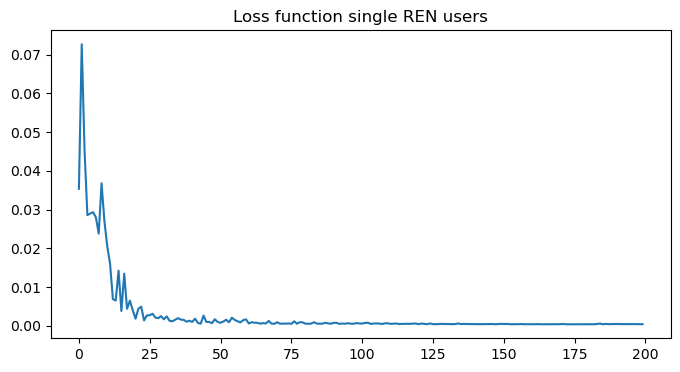

IndexError: index 2 is out of bounds for axis 1 with size 1

In [4]:
# Train single REN USERS
epochs = 200
t_end = 2500

n = 2# input dimensions
inputnumberD = 1
p = 1  # output dimensions

n_xi = 10# nel paper n1, numero di stati
l = 10  # nel paper q, dimension of the square matrix D11 -- number of _non-linear layers_ of the RE
# Define the model
RENsys = REN(n, p, n_xi, l, gammaTrain = False, gamma=1)
# Define Loss function
MSE = nn.MSELoss()
# Define Optimization method
learning_rate = 1.0e-1
optimizer = torch.optim.Adam(RENsys.parameters(), lr=learning_rate)
optimizer.zero_grad()

LOSS = np.zeros(epochs)

for epoch in range(epochs):
    if epoch == epochs - epochs / 2:
        learning_rate = 1.0e-2
        optimizer = torch.optim.Adam(RENsys.parameters(), lr=learning_rate)
    if epoch == epochs - epochs / 6:
        learning_rate = 1.0e-3
        optimizer = torch.optim.Adam(RENsys.parameters(), lr=learning_rate)
    optimizer.zero_grad()
    loss = 0
    for exp in range(nExp - 1):
        y = torch.from_numpy(yExp[0, exp][14000:16500,1]).float().to(device).unsqueeze(1) #T_entering_users
        y = y.T
        yRENm = torch.randn(p, t_end, device=device, dtype=dtype)
        yRENm[:,0] = y[:,0]
        xi = torch.randn(n_xi)
        d = torch.cat((torch.from_numpy(buildtot[exp*30240 +14000:exp*30240 + 16500]).float().to(device), # Q_users
                       torch.from_numpy(yExp[0, exp][14000:16500, 0]).float().to(device).unsqueeze(1)), dim = 1) # T_rit
                       
        d = d.T
        for t in range(1, t_end):
            #u = torch.tensor([d[:, t]])
            yRENm[:, t], xi = RENsys(d[:, t - 1], xi, t)
        loss = loss + MSE(yRENm[:, 0:yRENm.size(1)], y[:, 0:t_end + 1])
        # ignorare da loss effetto condizione iniziale

    loss = loss / nExp
    #loss.backward()
    loss.backward(retain_graph=True)

    optimizer.step()
    RENsys.set_param()

    print(f"Epoch: {epoch + 1} \t||\t Loss: {loss}")
    print(f"L2 gain REN: {RENsys.gamma}")
    LOSS[epoch] = loss

plt.figure(figsize=(4 * 2, 4))
plt.plot(LOSS)
plt.title("Loss function single REN users")
plt.show()

yval = torch.from_numpy(yExp_val[0, exp][14000:16500, 1]).float().to(device).unsqueeze(1)#T_entering_users
yval = yval.T

yRENm_val = torch.zeros(p, t_end, device=device, dtype=dtype)
yRENm_val[:,0] = yval[:,0]
xiVal = torch.randn(n_xi)
dval = torch.cat((torch.from_numpy(buildtot_val[exp*30240 +14000:exp*30240 + 16500]).float().to(device),    # Q_users
                    torch.from_numpy(yExp_val[0, exp][14000:16500, 0]).float().to(device).unsqueeze(1)), dim = 1)  #T_rit
dval = dval.T
loss_val = 0
for t in range(1, t_end):
    #u = torch.tensor([dval[:, t]])
    yRENm_val[:, t], xiVal = RENsys(dval[:, t - 1], xiVal, t)
loss_val = loss_val + MSE(yRENm_val[:, 0:yRENm_val.size(1)], yval[:, 0:t_end + 1])

loss_val_REN_users = loss_val

plt.figure(figsize=(4 * 2, 4))
for out in range(p):
    plt.subplot(1, p, out+1)
    plt.plot(yRENm[out, 0:t_end].detach().numpy(), label='REN train users')
    plt.plot(y[out, 0:t_end].detach().numpy(), label='y train users')
    plt.title(r"h%i "%out + r"in train")  
plt.show()

plt.figure(figsize=(4 * 2, 4))
for out in range(p):
    plt.subplot(1, p, out+1)
    plt.plot(yRENm_val[out, 0:t_end].detach().numpy(), label='REN val users')
    plt.plot(yval[out, 0:t_end].detach().numpy(), label='y val')
    plt.title(r"h%i "%out + r"in val")  
plt.show()

pytorch_total_params_singleREN = sum(p.numel() for p in RENsys.parameters() if p.requires_grad)
print(f"Loss Validation single REN users: {loss_val_REN_users}")

# Save
torch.save({
    'epoch': epoch,
    'model_state_dict': RENsys.state_dict(),
    'loss': loss,
}, f'checkpoint_users_epoch_{epoch+1}.pth')

(10080, 2)


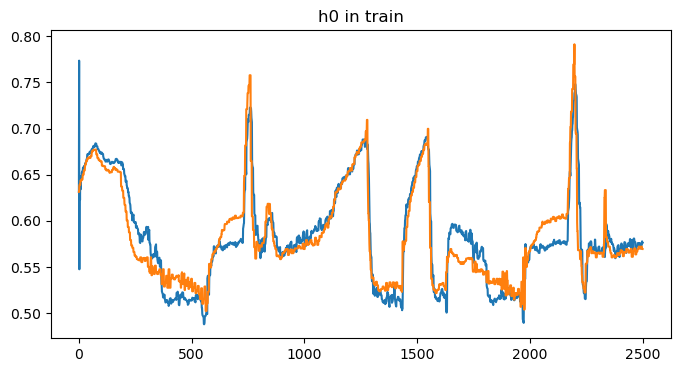

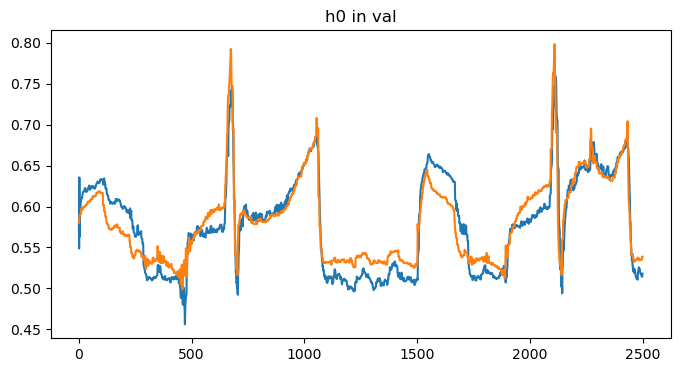

Loss Validation single REN users: 0.0004812543047592044


In [ ]:
yval = torch.from_numpy(yExp_val[0, 0][4000:6500, 1]).float().to(device).unsqueeze(1)#T_entering_users
yval = yval.T
print(yExp_val[0,0].shape)
yRENm_val = torch.zeros(p, t_end, device=device, dtype=dtype)
yRENm_val[:,0] = yval[:,0]
xiVal = torch.randn(n_xi)
dval = torch.cat((torch.from_numpy(buildtot_val[0*30240 +4000:0*30240 + 6500]).float().to(device),    # Q_users
                    torch.from_numpy(yExp_val[0, 0][4000:6500, 0]).float().to(device).unsqueeze(1)), dim = 1)  #T_rit
dval = dval.T
loss_val = 0
for t in range(1, t_end):
    #u = torch.tensor([dval[:, t]])
    yRENm_val[:, t], xiVal = RENsys(dval[:, t - 1], xiVal, t)
loss_val = loss_val + MSE(yRENm_val[:, 0:yRENm_val.size(1)], yval[:, 0:t_end + 1])

loss_val_REN_users = loss_val

plt.figure(figsize=(4 * 2, 4))
for out in range(p):
    plt.subplot(1, p, out+1)
    plt.plot(yRENm[out, 0:t_end].detach().numpy(), label='REN train users')
    plt.plot(y[out, 0:t_end].detach().numpy(), label='y train users')
    plt.title(r"T_returning (output users)" + r"in train")  
plt.show()

plt.figure(figsize=(4 * 2, 4))
for out in range(p):
    plt.subplot(1, p, out+1)
    plt.plot(maxTrit*yRENm_val[out, 0:t_end].detach().numpy(), label='REN val users')
    plt.plot(maxTrit*yval[out, 0:t_end].detach().numpy(), label='y val')
    plt.title(r"T_returning (output users)" + r"in val")  
plt.show()

pytorch_total_params_singleREN = sum(p.numel() for p in RENsys.parameters() if p.requires_grad)
print(f"Loss Validation single REN users: {loss_val_REN_users}")

# Save
torch.save({
    'epoch': epoch,
    'model_state_dict': RENsys.state_dict(),
    'loss': loss,
}, f'checkpoint_users_epoch_{epoch+1}.pth')

Epoch: 1 	||	 Loss: 0.030230173841118813
L2 gain REN: 1
Epoch: 2 	||	 Loss: 0.001534758834168315
L2 gain REN: 1
Epoch: 3 	||	 Loss: 0.002414735732600093
L2 gain REN: 1
Epoch: 4 	||	 Loss: 0.002995626535266638
L2 gain REN: 1
Epoch: 5 	||	 Loss: 0.0464993491768837
L2 gain REN: 1
Epoch: 6 	||	 Loss: 0.002449554158374667
L2 gain REN: 1
Epoch: 7 	||	 Loss: 0.0032163653522729874
L2 gain REN: 1
Epoch: 8 	||	 Loss: 0.0017632369417697191
L2 gain REN: 1
Epoch: 9 	||	 Loss: 0.0018103490583598614
L2 gain REN: 1
Epoch: 10 	||	 Loss: 0.002186526544392109
L2 gain REN: 1


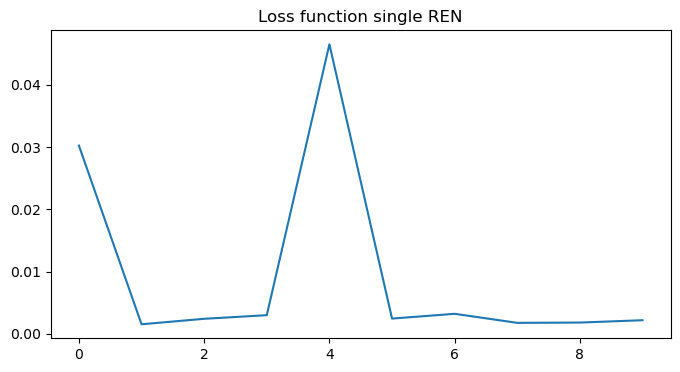

IndexError: too many indices for tensor of dimension 1

In [ ]:
# Train single REN ABSORBER
epochs = 10
t_end = 2500

n = 2  # input dimensions
p = 1  # output dimensions

n_xi = 10# nel paper n1, numero di stati
l = 10  # nel paper q, dimension of the square matrix D11 -- number of _non-linear layers_ of the RE
# Define the model
RENsys = REN(n, p, n_xi, l, gammaTrain = False, gamma= 1)
# Define Loss function
MSE = nn.MSELoss()
# Define Optimization method
learning_rate = 1.0e-1
optimizer = torch.optim.Adam(RENsys.parameters(), lr=learning_rate)
optimizer.zero_grad()

LOSS = np.zeros(epochs)

for epoch in range(epochs):
    if epoch == epochs - epochs / 2:
        learning_rate = 1.0e-2
        optimizer = torch.optim.Adam(RENsys.parameters(), lr=learning_rate)
    if epoch == epochs - epochs / 6:
        learning_rate = 1.0e-3
        optimizer = torch.optim.Adam(RENsys.parameters(), lr=learning_rate)
    optimizer.zero_grad()
    loss = 0
    for exp in range(nExp - 1):
        y = torch.from_numpy(Toutass_t[exp*30240 +14000:exp*30240 + 16500]).float().to(device) #Tourass
        y = y.T
        yRENm = torch.randn(p, t_end, device=device, dtype=dtype)
        yRENm[:,0] = y[:,0]
        xi = torch.randn(n_xi)
        d = torch.cat(( torch.from_numpy(yExp[0, exp][14000:16500,0]).float().to(device).unsqueeze(1),#T_rit
                        torch.from_numpy(dExp[0, exp][14000:16500,-1]).float().to(device).unsqueeze(1)), dim=1)#Q_abs
                       
        d = d.T
        for t in range(1, t_end):
            #u = torch.tensor([d[inputnumberD, t]])
            yRENm[:, t], xi = RENsys(d[:,t-1], xi, t)
        loss = loss + MSE(yRENm[:, 0:yRENm.size(1)], y[:, 0:t_end + 1])
        # ignorare da loss effetto condizione iniziale

    loss = loss / nExp
    #loss.backward()
    loss.backward(retain_graph=True)

    optimizer.step()
    RENsys.set_param()

    print(f"Epoch: {epoch + 1} \t||\t Loss: {loss}")
    print(f"L2 gain REN: {RENsys.gamma}")
    LOSS[epoch] = loss

plt.figure(figsize=(4 * 2, 4))
plt.plot(LOSS)
plt.title("Loss function single REN")
plt.show()



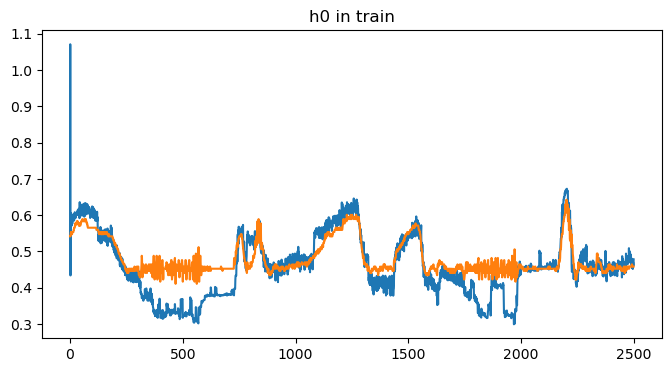

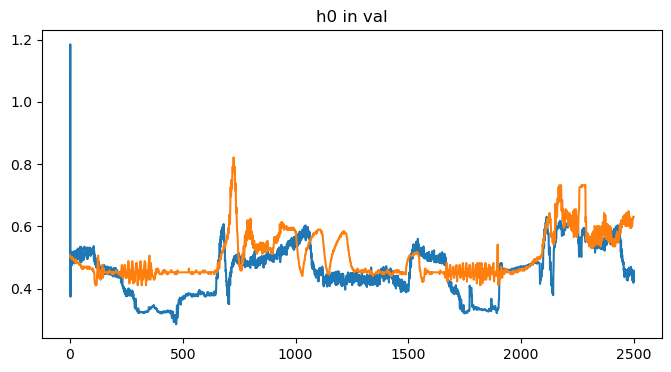

Loss Validation single REN absorber: 0.007170372176915407


In [ ]:
yval = torch.from_numpy(Toutass_t[0*30240 +4000:0*30240 + 6500]).float().to(device) #Toutass
yval = yval.T

yRENm_val = torch.zeros(p, t_end, device=device, dtype=dtype)
yRENm_val[:,0] = yval[:,0]
xiVal = torch.randn(n_xi)
dval = torch.cat(( torch.from_numpy(yExp_val[0,0][4000:6500,0]).float().to(device).unsqueeze(1), #T_rit
                        torch.from_numpy(dExp_val[0, 0][4000:6500,-1]).float().to(device).unsqueeze(1)), dim=1) # Qabs
dval= dval.T
loss_val = 0
for t in range(1, t_end):
    yRENm_val[:, t], xiVal = RENsys(dval[:,t-1], xiVal, t)
loss_val = loss_val + MSE(yRENm_val[:, 0:yRENm_val.size(1)], yval[:, 0:t_end + 1])

loss_val_REN = loss_val

plt.figure(figsize=(4 * 2, 4))
for out in range(p):
    plt.subplot(1, p, out+1)
    plt.plot(maxTabs*yRENm[out, 0:t_end].detach().numpy(), label='REN train absorber')
    plt.plot(maxTabs*y[out, 0:t_end].detach().numpy(), label='y train')
    plt.title(r"T_absorber" + r"in train")  
plt.show()

plt.figure(figsize=(4 * 2, 4))
for out in range(p):
    plt.subplot(1, p, out+1)
    plt.plot(maxTabs*yRENm_val[out, 0:t_end].detach().numpy(), label='REN val absorber')
    plt.plot(maxTabs*yval[out, 0:t_end].detach().numpy(), label='y val')
    plt.title(r"T_absorber" + r"in val")  
plt.show()

pytorch_total_params_singleREN = sum(p.numel() for p in RENsys.parameters() if p.requires_grad)
print(f"Loss Validation single REN absorber: {loss_val_REN}")

# Save
torch.save({
    'epoch': epoch,
    'model_state_dict': RENsys.state_dict(),
    'loss': loss,
}, f'checkpoint_absorber_epoch_{epoch+1}.pth')

Epoch: 1 	||	 Loss: 0.002167941303923726
L2 gain REN: 1
Epoch: 2 	||	 Loss: 0.0011916873045265675
L2 gain REN: 1
Epoch: 3 	||	 Loss: 0.012670439667999744
L2 gain REN: 1
Epoch: 4 	||	 Loss: 0.002851286204531789
L2 gain REN: 1
Epoch: 5 	||	 Loss: 0.0009079389274120331
L2 gain REN: 1
Epoch: 6 	||	 Loss: 0.004146326333284378
L2 gain REN: 1
Epoch: 7 	||	 Loss: 0.002618184080347419
L2 gain REN: 1
Epoch: 8 	||	 Loss: 0.0014483074191957712
L2 gain REN: 1
Epoch: 9 	||	 Loss: 0.0009760511456988752
L2 gain REN: 1
Epoch: 10 	||	 Loss: 0.000864457746502012
L2 gain REN: 1


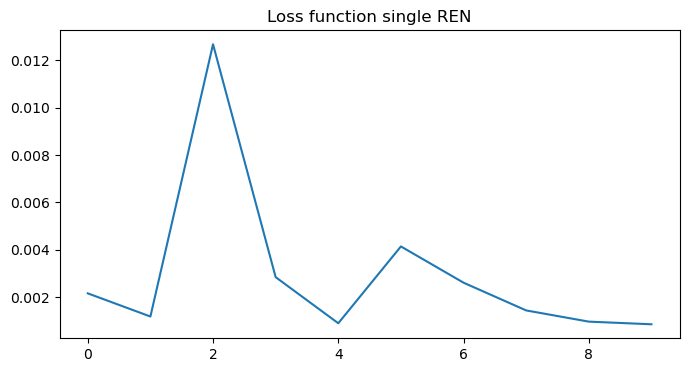

In [4]:
# Train single REN CHILLERS
epochs = 10
t_end = 2500

n = 2  # input dimensions
p = 1  # output dimensions

n_xi = 10# nel paper n1, numero di stati
l = 10  # nel paper q, dimension of the square matrix D11 -- number of _non-linear layers_ of the RE
# Define the model
RENsys = REN(n, p, n_xi, l, gammaTrain = False, gamma=1)
# Define Loss function
MSE = nn.MSELoss()
# Define Optimization method
learning_rate = 1.0e-1
optimizer = torch.optim.Adam(RENsys.parameters(), lr=learning_rate)
optimizer.zero_grad()

LOSS = np.zeros(epochs)

for epoch in range(epochs):
    if epoch == epochs - epochs / 2:
        learning_rate = 1.0e-2
        optimizer = torch.optim.Adam(RENsys.parameters(), lr=learning_rate)
    if epoch == epochs - epochs / 6:
        learning_rate = 1.0e-3
        optimizer = torch.optim.Adam(RENsys.parameters(), lr=learning_rate)
    optimizer.zero_grad()
    loss = 0
    for exp in range(nExp - 1):
        y = torch.from_numpy(Toutchill_t[exp*30240 +14000:exp*30240 + 16500]).float().to(device) #Toutchill
        y = y.T
        yRENm = torch.randn(p, t_end, device=device, dtype=dtype)
        yRENm[:,0] = y[:,0]
        xi = torch.randn(n_xi)
        d = torch.cat(( torch.from_numpy(yExp[0, exp][14000:16500,0]).float().to(device).unsqueeze(1), #Trit
                        torch.from_numpy(dExp[0, exp][14000:16500,-2]).float().to(device).unsqueeze(1)), dim=1)#I/O chillers
                       
        d = d.T
        for t in range(1, t_end):
            #u = torch.tensor([d[inputnumberD, t]])
            yRENm[:, t], xi = RENsys(d[:,t-1], xi, t)
        loss = loss + MSE(yRENm[:, 0:yRENm.size(1)], y[:, 0:t_end + 1])
        # ignorare da loss effetto condizione iniziale

    loss = loss / nExp
    #loss.backward()
    loss.backward(retain_graph=True)

    optimizer.step()
    RENsys.set_param()

    print(f"Epoch: {epoch + 1} \t||\t Loss: {loss}")
    print(f"L2 gain REN: {RENsys.gamma}")
    LOSS[epoch] = loss

plt.figure(figsize=(4 * 2, 4))
plt.plot(LOSS)
plt.title("Loss function single REN")
plt.show()



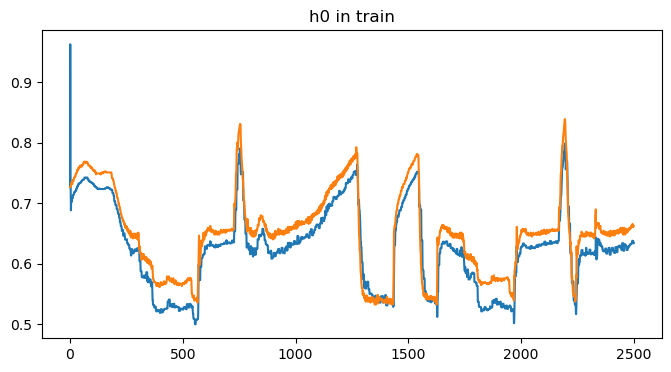

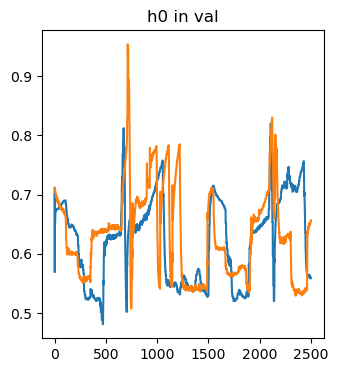

Loss Validation single REN chillers: 0.007960662245750427


In [ ]:
yval = torch.from_numpy(Toutchill_t[0*30240 +4000:0*30240 + 6500]).float().to(device) #Toutchill
yval = yval.T

yRENm_val = torch.zeros(p, t_end, device=device, dtype=dtype)
yRENm_val[:,0] = yval[:,0]
xiVal = torch.randn(n_xi)
dval = torch.cat(( torch.from_numpy(yExp_val[0, 0][4000:6500,0]).float().to(device).unsqueeze(1), #Trit
                        torch.from_numpy(dExp_val[0, 0][4000:6500,-2]).float().to(device).unsqueeze(1)), dim=1)#I/O chillers
dval = dval.T
loss_val = 0
for t in range(1, t_end):
    yRENm_val[:, t], xiVal = RENsys(dval[:,t-1], xiVal, t)
loss_val = loss_val + MSE(yRENm_val[:, 0:yRENm_val.size(1)], yval[:, 0:t_end + 1])

loss_val_REN = loss_val

plt.figure(figsize=(4 * 2, 4))
for out in range(p):
    plt.subplot(1, p, out+1)
    plt.plot(maxTchill*yRENm[out, 0:t_end].detach().numpy(), label='REN train chillers')
    plt.plot(maxTchill*y[out, 0:t_end].detach().numpy(), label='y train')
    plt.title(r"T_chillers output" + r"in train")  
plt.show()

plt.figure(figsize=(4 * 2, 4))
for out in range(p):
    plt.subplot(1, p, out+1)
    plt.plot(maxTchill*yRENm_val[out, 0:t_end].detach().numpy(), label='REN val chillers')
    plt.plot(maxTchill*yval[out, 0:t_end].detach().numpy(), label='y val')
    plt.title(r"T_chillers output" + r"in val")  
plt.show()

pytorch_total_params_singleREN = sum(p.numel() for p in RENsys.parameters() if p.requires_grad)
print(f"Loss Validation single REN chillers: {loss_val_REN}")

# Save
torch.save({
    'epoch': epoch,
    'model_state_dict': RENsys.state_dict(),
    'loss': loss,
}, f'checkpoint_chillers_epoch_{epoch+1}.pth')

In [5]:
# TRAIN OF NETWORKED RENs
epochs = 10
t_end = 2500

torch.manual_seed(2)
N = 3 # Number of interconnected systems

n = torch.tensor([2, 2, 2])  # input dimensions
p = torch.tensor([1, 1, 1])  # output dimensions

n_xi = np.array([10, 10, 10]) # nel paper n1, numero di stati
l = np.array([10, 10, 10])  # nel paper q, dimension of the square matrix D11 -- number of _non-linear layers_ of the RE

alpha = 1
beta = 1

Muy = torch.cat((torch.tensor([[0, alpha, beta], [1, 0, 0], [1, 0, 0]]), torch.zeros(3,3)), dim=0)
Muy = Muy.float()

Mud = torch.cat((torch.zeros(3,3), torch.eye(3)), dim=0)
Mey = torch.tensor([[0, alpha, beta], [1, 0, 0]])

# Define the system
RENsys = NetworkedRENs(N, Muy, Mud, Mey, n, p, n_xi, l)

# Define Loss function
MSE = nn.MSELoss()

# Define Optimization method
learning_rate = 1.0e-1
optimizer = torch.optim.Adam(RENsys.parameters(), lr=learning_rate)
optimizer.zero_grad()

LOSS = np.zeros(epochs)
loss = 0

for epoch in range(epochs):
    if epoch == epochs - epochs / 2:
        learning_rate = 1.0e-2
        optimizer = torch.optim.Adam(RENsys.parameters(), lr=learning_rate)
    if epoch == epochs - epochs / 6:
        learning_rate = 1.0e-3
        optimizer = torch.optim.Adam(RENsys.parameters(), lr=learning_rate)
    optimizer.zero_grad()
    loss = 0
    for exp in range(nExp - 1):
        xi = []
        y = torch.cat((torch.from_numpy(yExp[0, exp][14000:16500,0]).float().to(device).unsqueeze(1),
                       torch.from_numpy(Toutass_t[exp*30240 +14000:exp*30240 + 16500]).float().to(device),
                       torch.from_numpy(Toutchill_t[exp*30240 +14000:exp*30240 + 16500]).float().to(device)), dim=1)
        y = y.T
        yRENm = torch.randn(3,t_end , device=device, dtype=dtype)
        yRENm[0,:] = y[0,:]
        for j in range(N):
            xi.append(torch.randn(RENsys.r[j].n, device=device, dtype=dtype))
        d = torch.cat((torch.from_numpy(buildtot[exp*30240 +14000:exp*30240 + 16500]).float().to(device),
                       torch.from_numpy(dExp[0, exp][14000:16500,-1]).float().to(device).unsqueeze(1),
                       torch.from_numpy(dExp[0, exp][14000:16500,-2]).float().to(device).unsqueeze(1)), dim=1)
        d = d.T
        xi = torch.cat(xi)
        for t in range(1, t_end):
            yRENm[:, t], xi = RENsys(t, d[:, t - 1], xi)

        loss = loss + MSE(yRENm[:, 0:yRENm.size(1)], y[:, 0:t_end + 1])
        # ignorare da loss effetto condizione iniziale

    loss = loss / nExp
    loss.backward()
    # loss.backward(retain_graph=True)

    optimizer.step()

    print(f"Epoch: {epoch + 1} \t||\t Loss: {loss}")
    for net in range(N):
        print(f"L2 gain REN%i"%net+":%.1f"%RENsys.r[net].gamma)
    LOSS[epoch] = loss
    
    # Or save a checkpoint with optimizer and other details
    torch.save({
        'epoch': epoch,
        'model_state_dict': RENsys.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'loss': loss,
    }, f'better_epoch_{epoch+1}.pth')




c:\Users\adela\OneDrive\Documents\EPFL_MA3\Projet_de_semester\SysID_RNN_modif\ECC-Distributed_Git\ECC-Distributed_Git\models.py:238: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental featu

Epoch: 1 	||	 Loss: 0.607380747795105
L2 gain REN0:3.9
L2 gain REN1:6.9
L2 gain REN2:3.5
Epoch: 2 	||	 Loss: 0.37702733278274536
L2 gain REN0:2.2
L2 gain REN1:4.9
L2 gain REN2:3.3
Epoch: 3 	||	 Loss: 0.2665393054485321
L2 gain REN0:1.9
L2 gain REN1:6.8
L2 gain REN2:3.0
Epoch: 4 	||	 Loss: 0.18808035552501678
L2 gain REN0:1.5
L2 gain REN1:5.8
L2 gain REN2:2.8
Epoch: 5 	||	 Loss: 0.1618308424949646
L2 gain REN0:1.3
L2 gain REN1:5.2
L2 gain REN2:2.7
Epoch: 6 	||	 Loss: 0.09433989226818085
L2 gain REN0:1.1
L2 gain REN1:4.8
L2 gain REN2:2.6
Epoch: 7 	||	 Loss: 0.07838011533021927
L2 gain REN0:1.1
L2 gain REN1:4.8
L2 gain REN2:2.6
Epoch: 8 	||	 Loss: 0.06989532709121704
L2 gain REN0:1.1
L2 gain REN1:4.8
L2 gain REN2:2.6
Epoch: 9 	||	 Loss: 0.06490591168403625
L2 gain REN0:1.1
L2 gain REN1:4.8
L2 gain REN2:2.6
Epoch: 10 	||	 Loss: 0.06088542938232422
L2 gain REN0:1.1
L2 gain REN1:4.8
L2 gain REN2:2.6


In [8]:
import torch

# Load 
#checkpoint = torch.load('checkpoint_epoch_218.pth')
checkpoint = torch.load('better_epoch_10.pth')

t_end = 2500
nExp = 1

N = 3 # Number of interconnected systems

n = torch.tensor([2, 2, 2])  # input dimensions
p = torch.tensor([1, 1, 1])  # output dimensions

n_xi = np.array([10, 10, 10]) # nel paper n1, numero di stati
l = np.array([10, 10, 10])  # nel paper q, dimension of the square matrix D11 -- number of _non-linear layers_ of the RE

alpha = 0.6
beta = 0.4

Muy = torch.cat((torch.tensor([[0, alpha, beta], [1, 0, 0], [1, 0, 0]]), torch.zeros(3,3)), dim=0)
Muy = Muy.float()

Mud = torch.cat((torch.zeros(3,3), torch.eye(3)), dim=0)
Mey = torch.tensor([[0, alpha, beta], [1, 0, 0]])

# Define the system
RENsys = NetworkedRENs(N, Muy, Mud, Mey, n, p, n_xi, l)

# Define Loss function
MSE = nn.MSELoss()
# Restore the model state
RENsys.load_state_dict(checkpoint['model_state_dict'])

# If needed, restore the optimizer state (for resuming training)
# optimizer.load_state_dict(checkpoint['optimizer_state_dict'])

# Retrieve the last epoch and loss
last_epoch = checkpoint['epoch']
last_loss = checkpoint['loss']

print(f"Resuming from Epoch {last_epoch + 1} with Loss: {last_loss}")

# Ensure the model is in evaluation mode for validation
RENsys.eval()

# Perform validation
with torch.no_grad():
    validation_loss = 0
    for exp in range(nExp - 1):
        xi = []
        yval = torch.cat((torch.from_numpy(yExp_val[0, exp][14000:16500, 0]).float().to(device).unsqueeze(1),
                       torch.from_numpy(Toutass_v[exp * 30240 + 14000:exp * 30240 + 16500]).float().to(device),
                       torch.from_numpy(Toutchill_v[exp * 30240 + 14000:exp * 30240 + 16500]).float().to(device)), dim=1)
        yval = yval.T
        yRENm_val = torch.randn(3, t_end, device=device, dtype=torch.float)
        yRENm_val[0, :] = yval[0, :]
        
        for j in range(N):
            xi.append(torch.randn(RENsys.r[j].in_features, device=device, dtype=torch.float))
            
        dval = torch.cat((torch.from_numpy(buildtot_val[exp * 30240 + 14000:exp * 30240 + 16500]).float().to(device),
                       torch.from_numpy(dExp_val[0, exp][14000:16500, -1]).float().to(device).unsqueeze(1),
                       torch.from_numpy(dExp_val[0, exp][14000:16500, -2]).float().to(device).unsqueeze(1)), dim=1)
        dval = dval.T
        xi = torch.cat(xi)
        
        for t in range(1, t_end):
            yRENm_val[:, t], xi = RENsys(t, dval[:, t - 1], xi)

        validation_loss += MSE(yRENm_val[:, 0:yRENm_val.size(1)], yval[:, 0:t_end + 1])

    validation_loss = validation_loss / nExp
    print(f"Validation Loss: {validation_loss}")


Resuming from Epoch 10 with Loss: 0.06088542938232422
Validation Loss: 0.0


C:\Users\adela\AppData\Local\Temp\ipykernel_34068\645423202.py:5: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load('better_epoch_10.pth')


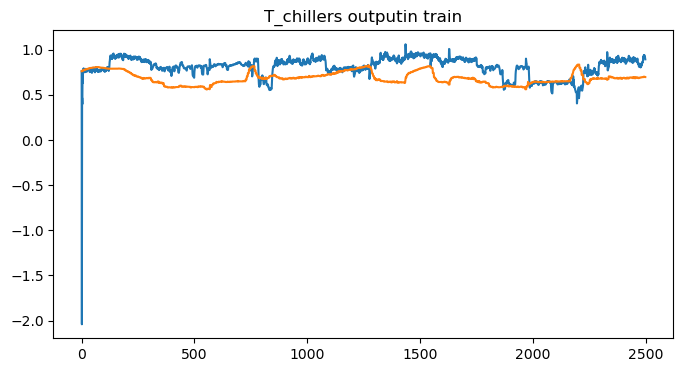

NameError: name 'yRENm_val' is not defined

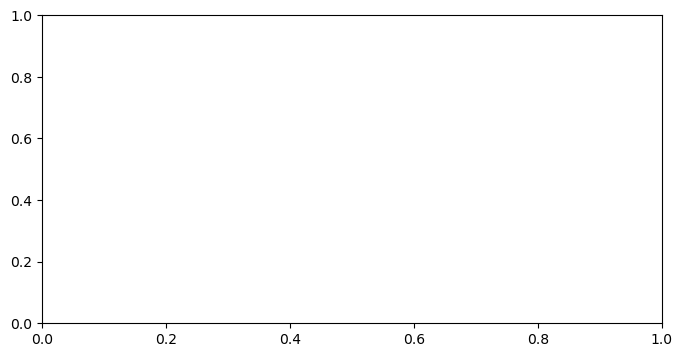

In [11]:
plt.figure(figsize=(4 * 2, 4))
for out in range(1):
    plt.subplot(1, 1, out+1)
    plt.plot(yRENm[out, 0:t_end].detach().numpy(), label='REN train chillers')
    plt.plot(y[out, 0:t_end].detach().numpy(), label='y train')
    plt.title(r"T_chillers output" + r"in train")  
plt.show()

plt.figure(figsize=(4 * 2, 4))
for out in range(1):
    plt.subplot(1, 1, out+1)
    plt.plot(yRENm_val[out, 0:t_end].detach().numpy(), label='REN val chillers')
    plt.plot(yval[out, 0:t_end].detach().numpy(), label='y val')
    plt.title(r"T_chillers output" + r"in val")  
plt.show()